<h1>Linear Regression - Customer Lifetime value</h1>
<p>This notebook provides an example code of analyzing <b>Customer lifetime value</b> using linear regression. The dependent variable which we will use in OLS model is <b>Customer lifetime value</b>. We would like to understand the realtionship between CLV and other variables in the dataset.
    
The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, outliers,summary statistics of our variables, etc)
<li>Checking for correlations between the variables, and drop one of correlated variables 
<li>Visualize the relationship between dependent variable (CLV) and some of variables which are highly correlated to CLV
<li>Construct the OLS model using statsmodel package
<li>Get summary of the model
<li>Interpret the results
<li><b>Model diagnostics</b>
<li><b>Training, testing</b>
</ol>
</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.api import qqplot
from statsmodels.formula.api import ols #for linear regression
import seaborn as sns #for heatmap
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan

# Description of Data

In [2]:
#read the data
data=pd.read_excel("CLV.xlsx")

In [3]:
#lets see how the data looks 
data.head()

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,Gender,Income,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [4]:
#let's check for NA's
data.isnull().values.any()

False

In [5]:
#let's get info about all the variables and the types of them
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Customer_Lifetime_Value          9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective_To_Date                9134 non-null datetime64[ns]
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location_Code                    9134 non-null object
Marital_Status                   9134 non-null object
Monthly_Premium_Auto             9134 non-null int64
Months_Since_Last_Claim          9134 non-null int64
Months_Since_Policy_Inception    9134 non-null int64
Number_of_Open_Complaints        9134 non-null int64
Number_of_Policies       

In [6]:
#let's separate numeric and object variables
data_numeric = data.select_dtypes(exclude=["object", "datetime64"])
data_object = data.select_dtypes(include=["object"])

In [7]:
data_object.head()

,Customer,State,Response,Coverage,Education,EmploymentStatus,Gender,Location_Code,Marital_Status,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,QZ44356,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,AI49188,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,WW63253,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,HB64268,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


In [8]:
del data_object["Customer"]

In [9]:
#let's see categories and number of observations in each category for object variables
for i in data_object.columns:
    j=data[i].value_counts()
    print(i,"\n",j,"\n","\n")
    print("--------------------")

State 
 California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64 
 

--------------------
Response 
 No     7826
Yes    1308
Name: Response, dtype: int64 
 

--------------------
Coverage 
 Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64 
 

--------------------
Education 
 Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64 
 

--------------------
EmploymentStatus 
 Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64 
 

--------------------
Gender 
 F    4658
M    4476
Name: Gender, dtype: int64 
 

--------------------
Location_Code 
 Suburban    5779
Rural       1773
Urban       1582
Name: Location_Code, dtype: int64 
 

--------------------
Marital_Status 
 Married     52

In [10]:
#let's check variables with zero variance(i.e. we have same values for all observations), 
#if there is any we will not include in our further analysis
data_numeric.var()==0

Customer_Lifetime_Value          False
Income                           False
Monthly_Premium_Auto             False
Months_Since_Last_Claim          False
Months_Since_Policy_Inception    False
Number_of_Open_Complaints        False
Number_of_Policies               False
Total_Claim_Amount               False
dtype: bool

In [11]:
data_numeric.corr()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
Customer_Lifetime_Value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
Income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly_Premium_Auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months_Since_Last_Claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months_Since_Policy_Inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number_of_Open_Complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number_of_Policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total_Claim_Amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


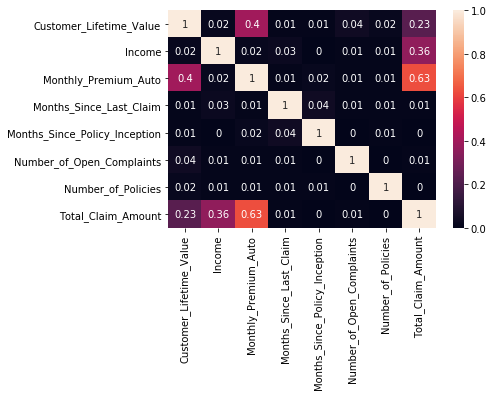

In [12]:
sns.heatmap(data_numeric.corr().abs().round(2), annot=True)
plt.show()

<b>We will not exclude any variable as the corr between variables is less than 0.75.</b>

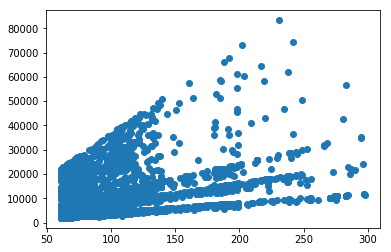

In [13]:
#as can be seen from the first heatmap, CLV has the highest correlation with Monthly Premium Auto
#the shape of graph gives us a hint that we may have heteroscedasticity in the model
plt.scatter(data_numeric.Monthly_Premium_Auto,data_numeric.Customer_Lifetime_Value)
plt.show()

# OLS Method

In [14]:
#after making necessary changes in numeric and object datasets(in our example no change was needed), 
#we will combine back the datasets
data_new=data_numeric.join(data_object,how='outer')

In [15]:
var=data_new.columns.tolist()
var

['Customer_Lifetime_Value',
 'Income',
 'Monthly_Premium_Auto',
 'Months_Since_Last_Claim',
 'Months_Since_Policy_Inception',
 'Number_of_Open_Complaints',
 'Number_of_Policies',
 'Total_Claim_Amount',
 'State',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Gender',
 'Location_Code',
 'Marital_Status',
 'Policy_Type',
 'Policy',
 'Renew_Offer_Type',
 'Sales_Channel',
 'Vehicle_Class',
 'Vehicle_Size']

In [16]:
#removing Customer_Lifetime_Value
#removing Customer ID(as it doesn't give any meaningful info)
del var[0]

In [17]:
var

['Income',
 'Monthly_Premium_Auto',
 'Months_Since_Last_Claim',
 'Months_Since_Policy_Inception',
 'Number_of_Open_Complaints',
 'Number_of_Policies',
 'Total_Claim_Amount',
 'State',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Gender',
 'Location_Code',
 'Marital_Status',
 'Policy_Type',
 'Policy',
 'Renew_Offer_Type',
 'Sales_Channel',
 'Vehicle_Class',
 'Vehicle_Size']

In [18]:
#as there are many variables, not to input all manually let's create formula 
formula="+".join(var)
formula="Customer_Lifetime_Value~"+formula
formula

'Customer_Lifetime_Value~Income+Monthly_Premium_Auto+Months_Since_Last_Claim+Months_Since_Policy_Inception+Number_of_Open_Complaints+Number_of_Policies+Total_Claim_Amount+State+Response+Coverage+Education+EmploymentStatus+Gender+Location_Code+Marital_Status+Policy_Type+Policy+Renew_Offer_Type+Sales_Channel+Vehicle_Class+Vehicle_Size'

In [19]:
#first let's include all the explaining variables in the model(high correlated ones are already excluded)
model1=ols(formula=formula, data=data_new)

In [20]:
results=model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.169
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     38.60
Date:                     Tue, 09 Oct 2018   Prob (F-statistic):          6.92e-323
Time:                             17:15:12   Log-Likelihood:                -92812.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9085   BIC:                         1.861e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          1486.6386    903.661      1.645      0.100    -284.740    3258.017
State[T.California]                  39.9647    189.426      0.211      0.833    -331.354     411.283
State[T.Nevada]                      45.7021    261.160      0.175      0.861    -466.231     557.635
State[T.Oregon]                      84.9912    196.050      0.434      0.665    -299.312     469.294
State[T.Washington]                 164.3324    269.980      0.609      0.543    -364.888     693.553
Response[T.Yes]                    -215.9162    207.436     -1.041      0.298    -622.538     190.705
Coverage[T.Extended]                130.1678    249.287      0.522      0.602    -358.490     618.826
Coverage[T.Premium]                  61.7491    527.605      0.117      0.907    -972.476    1095.974
Education[T.College]                 -1.5962    171.219     -0.009      0.993    -337.225     334.032
Education[T.Doctor]                -197.9744    362.976     -0.545      0.585    -909.488     513.540
Education[T.High School or Below]   388.9735    173.415      2.243      0.025      49.041     728.906
Education[T.Master]                 157.9503    262.899      0.601      0.548    -357.390     673.291
EmploymentStatus[T.Employed]        700.4418    354.477      1.976      0.048       5.587    1395.296
EmploymentStatus[T.Medical Leave]   210.8226    436.143      0.483      0.629    -644.116    1065.761
EmploymentStatus[T.Retired]          64.6393    502.732      0.129      0.898    -920.829    1050.108
EmploymentStatus[T.Unemployed]        9.1563    357.613      0.026      0.980    -691.846     710.158
Gender[T.M]                        -143.5239    132.973     -1.079      0.280    -404.181     117.133
Location_Code[T.Suburban]           -73.7895    263.381     -0.280      0.779    -590.076     442.497
Location_Code[T.Urban]              128.8756    241.416      0.534      0.593    -344.355     602.106
Marital_Status[T.Married]          -177.6388    194.800     -0.912      0.362    -559.490     204.212
Marital_Status[T.Single]           -490.7108    225.714     -2.174      0.030    -933.161     -48.260
Policy_Type[T.Personal Auto]       -305.6726    256.741     -1.191      0.234    -808.943     197.598
Policy_Type[T.Special Auto]         165.6132    362.670      0.457      0.648    -545.301     876.527
Policy[T.Corporate L2]            -1007.2895    420.508     -2.395      0.017   -1831.581    -182.998
Policy[T.Corporate L3]             -668.9524    386.386     -1.731      0.083   -1426.357      88.452
Policy[T.Personal L1]              -161.3307    163.621     -0.986      0.324    -482.065     159.404
Policy[T.Personal L2]                -6.5954    141.822     -0.047    

# Model diagnostics

<h2> Cecking for Linearity and Equal variance</h2>

Residuals of the model will be used to test for linearity and for other assumptions as well.

1. Both linearity and equal variance can be tested by plotting residuals vs. predictions (residuals are prediction errors)
2. We will use <b>Harvey collier</b> test for linearity
3. <b>Breusch-Pagan</b> test for homoscedasticity


In [21]:
#residuals of the model
residuals=results.resid
residuals.head(10)

0    -4006.075515
1     -189.280585
2     3352.672758
3    -1632.830500
4    -3821.003601
5     2535.728535
6    -1082.944224
7     -715.449474
8    18132.299230
9    -1273.953623
dtype: float64

In [22]:
#let's actually get residual values
#first, we need to get predicted values from the results of the model
#second, we should calculate the difference between predicted and true values of cons. conf. index
pred_values=results.predict()
true_values=data_new.Customer_Lifetime_Value
resid=true_values-pred_values

In [23]:
#we can see that we got the same results
resid.head(10)

0    -4006.075515
1     -189.280585
2     3352.672758
3    -1632.830500
4    -3821.003601
5     2535.728535
6    -1082.944224
7     -715.449474
8    18132.299230
9    -1273.953623
Name: Customer_Lifetime_Value, dtype: float64

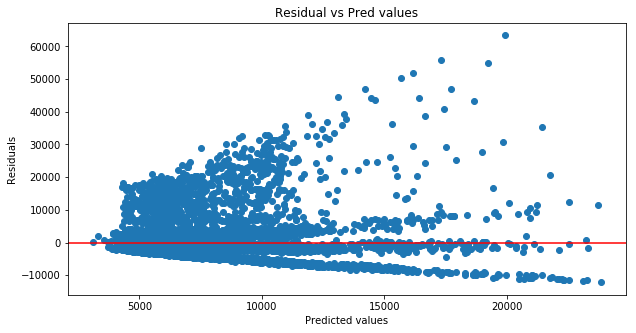

In [24]:
#lets plot predicted values vs residuals
plt.figure(figsize=(10,5))
plt.scatter(pred_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residual vs Pred values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

In [25]:
#Rainbow test for linearity
#The Null hypothesis is that the regression is correctly modelled as linear
linear_rainbow(results)

(1.016497272996893, 0.2907128743692436)

<b>2nd value presents p-value</b>

In [26]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
#Small p-value shows that there is violation of homoscedasticity
het_breuschpagan(residuals,model1.exog)

(553.6378918541901,
 4.3478807978761946e-86,
 12.212480526512033,
 2.5858596519147796e-90)

<b>2nd and 4th values are p-values</b>

<h2>Normality</h2>

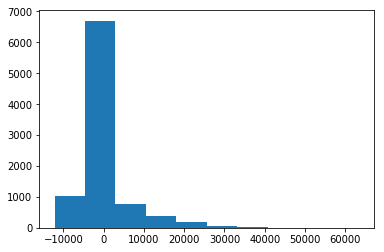

In [36]:
#visual presentation- histogram
plt.hist(residuals)
plt.show()

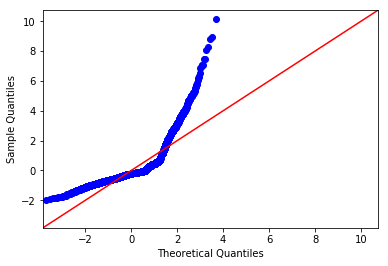

In [28]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

<b>Jarque-Bera normality test values are given in the model summary above. From where we could conclude that normality was violated. However, let's run another test of normality: Shapiro-Wilk test.</b>


In [29]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
#We reject the Null hypothesis which means that we can state with 95% confidence that our data is not normal
stat,p_value = shapiro(residuals)
print(stat,p_value)

0.7270915508270264 0.0


C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Training, Testing

In [30]:
train,test=train_test_split(data_new,test_size=0.25,random_state=42)

In [31]:
#train
model_linear=ols(formula=formula, data=train).fit()

In [32]:
#test
prediction=model_linear.predict(test)

In [33]:
prediction.head()

708     9553.114913
47      5678.521863
3995    7281.278804
1513    9291.580399
3686    7215.763007
dtype: float64

In [34]:
#let's calculate R^2
r2_sc=r2_score(test.Customer_Lifetime_Value,prediction)
print(r2_sc)

0.1476485530363032
